# SVM Tutorial Note
Business Analytics 두번째 주제인 kernel based learning의 SVM에 대한 tutorial note입니다.
이번 tutorial에서의 목적은 다음과 같습니다.
- navie SVM w/ soft-margin 구현
- linear SVM과 Kernel(rbf) SVM 성능 비교
- k-NN, LDA와 성능 비교  


먼저 cvxopt 패키지를 사용하여 SVM의 원문제를 풀어 SVM을 구현한 뒤, kernel 함수를 적용해봅니다. 이후 다른 분류 머신러닝 모델인 k-NN과 LDA을 추가적으로 비교해볼 예정입니다.

In [338]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

## 0. Data Loading & Pre-processing
데이터는 kaggle에 있는 'Credit Card Fraud Detection' 데이터를 불러와 분석에 사용하였습니다. 각 변수의 설명은 아래와 같습니다.
- Time: 첫 거래와의 경과 시간
- v1~v28: 민감 개인정보 보호를 위해 PCA로 차원 축소된 특징 변수

In [158]:
data_origin = pd.read_csv('./data/creditcard.csv', encoding ='cp949')

- 클래스의 균형을 위해 Class 값이 0과 1인 데이터를 100개씩 샘플링이
- 이후 Class 값이 0인 값은 SVM의 계산을 위해 -1로 대체

In [189]:
data_c1_ = data_origin[data_origin['Class']==1]
data_c0_ = data_origin[data_origin['Class']==0]

data_c1_50_ = data_c1_.sample(n=350)
data_c0_50_ = data_c0_.sample(n=350)

data_c0_50_['Class'] = -1

data_ = pd.concat([data_c1_50_, data_c0_50_], axis=0)

In [237]:
# split data (tr, te)
train_, test_  = train_test_split(data_, test_size=0.3, random_state=45)

In [238]:
columns_ = train_.columns

- 사전 함수 구축
    - Kernel 함수
    - 각 데이터의 연산을 위해 $(X-X_{mean})/X_{std}$ 방식의 normalize 함수
    - 평가 시 예측을 위한 함수

In [239]:
# Kernel function
def Kernel_(x1, x2, params, type_):
  # rbf
  if type_ == 'rbf' : 
    X_norm = np.sum(x1 ** 2, axis=-1)
    Y_norm = np.sum(x2 ** 2, axis=-1)
    Kernel = np.exp(-params*(X_norm[:, None] + Y_norm[None, :] - 2*np.dot(x1, x2.T)))
    return Kernel

  # linear
  elif type_ == 'linear':
    Kernel = np.dot(x1, x2.T)
    return Kernel

# normalize
def Standar_(X) :
    X = np.array(X)
    return (X - X.mean(axis =0)) / X.std(axis = 0), X.mean(axis =0), X.std(axis = 0)

# predict classification
def predict(X, w, b):
    infer = np.dot(X, w) - b
    return np.sign(infer)

## 1. Linear SVM (soft-margin)

In [240]:
# scaling train data
X = Standar_(np.array(train_[columns_[:-1]]))[0]
y = np.array(train_[columns_[-1]])*1.
y = y.reshape(-1,1)

# scaling test data
X_test_ = Standar_(np.array(test_[columns_[:-1]]))[0]
y_test_ = np.array(test_[columns_[-1]])*1.

- navie SVM 구현!

SVM의 원 문제를 Lagrangian multiplier를 이용하여 Lagrangian primal로 변환하면 이 때의 dual은 다음과 같습니다.
$$max \; \sum_{i=1}^N \alpha_i − {{1}\over{2}}\sum_{i=1}^N \sum_{j=1}^N y_iy_j \alpha_i \alpha_j x_ix_j$$
$$ s.t. \; \sum_{i=1}^n \alpha_i y_i = 0 \; and \; 0 \leq \alpha_i \leq C$$


CVXOPT의 solver는 (P, q[, G, h[, A, b[, solver[, initvals]]]])와 같은 형태로 parameter들을 받아 아래와 같은 수식을 만족시키는 모수를 찾습니다. 여기서의 P, q, G, h, A, b를 적절하게 설정하여 cvxopt가 lagrangian dual을 풀 수 있도록 하는 것이 필요합니다.
$$min \; {{1}\over{2}}xT P x + qT x$$
$$s.t. \; Gx≤h, \; Ax = b$$

In [241]:
# SVM sol function
def svm_solver(X, y, C, param=0, type='linear', output_print=False):
    H = Kernel_(X, X, params=param , type_=type)*1.
    H *= y@y.T

    m,n = X.shape

    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye(m), np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m)*C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))

    # run
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    print('-'*70)

    # results
    w = ((y*alphas).T@X).reshape(-1,1)
    S = ((alphas > 1e-4) & (alphas < C-1e-4)).flatten()
    b = y[S] - np.sum(Kernel_(X, X[S], params=2,  type_='rbf')*y*alphas, axis=0).reshape(-1,1)

    if output_print == True:
        print('Alphas = ', alphas[(alphas > 1e-4) & (alphas < C-1e-4)])
        print('-'*70)
        print('w = ', w.flatten())
        print('-'*70)
        print('b = ', np.mean(b))
        print('-'*70)
        print("support vector: ", np.array(range(m))[S])
    else:
        pass
    
    return alphas[(alphas > 1e-4) & (alphas < C-1e-4)], w.flatten(), np.mean(b), np.array(range(m))[S]

In [342]:
_, lin_w, lin_b, _ = svm_solver(X, y, C=10, output_print=True)

     pcost       dcost       gap    pres   dres
 0: -8.3470e+02 -5.9806e+04  2e+05  1e+00  5e-13
 1: -5.4830e+02 -3.0507e+04  5e+04  3e-01  4e-13
 2: -2.5636e+02 -1.2218e+04  2e+04  9e-02  2e-13
 3: -1.5493e+02 -8.8298e+03  1e+04  6e-02  1e-13
 4: -7.1798e+01 -4.0053e+03  5e+03  2e-02  1e-13
 5: -1.1683e+02 -1.5638e+03  2e+03  5e-03  9e-14
 6: -1.7975e+02 -7.7131e+02  7e+02  2e-03  9e-14
 7: -2.1539e+02 -5.7466e+02  4e+02  7e-04  1e-13
 8: -2.4511e+02 -4.3731e+02  2e+02  3e-04  1e-13
 9: -2.5845e+02 -3.8531e+02  1e+02  2e-04  1e-13
10: -2.7343e+02 -3.3462e+02  6e+01  5e-05  1e-13
11: -2.7913e+02 -3.2171e+02  4e+01  2e-05  1e-13
12: -2.8857e+02 -3.0088e+02  1e+01  3e-06  2e-13
13: -2.9157e+02 -2.9589e+02  4e+00  1e-06  1e-13
14: -2.9268e+02 -2.9379e+02  1e+00  1e-14  2e-13
15: -2.9317e+02 -2.9322e+02  5e-02  2e-14  1e-13
16: -2.9320e+02 -2.9320e+02  6e-04  3e-14  1e-13
17: -2.9320e+02 -2.9320e+02  6e-06  2e-14  2e-13
Optimal solution found.
----------------------------------------------

- train data로 만든 SVM에 대해 test data를 사용해 평가

In [343]:
# predict
X_test_re = predict(X_test_, lin_w, lin_b)

# compute acc
# cost 10
results = X_test_re == y_test_
correct_ = np.sum(results)
print('Accuracy Test set using Linear SVM(c=10): ', correct_ / len(X_test_))

Accuracy Test set using Linear SVM(c=10):  0.8380952380952381


In [244]:
# Cost is 50
_, lin_w, lin_b, _ = svm_solver(X, y, C=50)

# predict
X_test_re = predict(X_test_, lin_w, lin_b)

# compute acc
results = X_test_re == y_test_
correct_ = np.sum(results)
print('Accuracy Test set using Linear SVM: ', correct_ / len(X_test_))

     pcost       dcost       gap    pres   dres
 0: -2.8914e+03 -1.2972e+06  4e+06  1e+00  2e-12
 1: -4.7933e+02 -6.2948e+05  1e+06  2e-01  1e-12
 2:  1.9787e+03 -2.2058e+05  4e+05  7e-02  8e-13
 3:  3.1466e+03 -1.4729e+05  2e+05  4e-02  6e-13
 4:  2.3704e+03 -6.5160e+04  9e+04  1e-02  4e-13
 5:  8.7432e+02 -2.2090e+04  3e+04  4e-03  4e-13
 6: -4.0744e+01 -8.8065e+03  1e+04  9e-04  4e-13
 7: -6.2481e+02 -4.2558e+03  4e+03  3e-04  4e-13
 8: -8.5428e+02 -2.8071e+03  2e+03  9e-05  4e-13
 9: -1.0256e+03 -2.0595e+03  1e+03  3e-05  5e-13
10: -1.1385e+03 -1.8271e+03  7e+02  9e-06  5e-13
11: -1.1534e+03 -1.7182e+03  6e+02  4e-06  5e-13
12: -1.2113e+03 -1.5805e+03  4e+02  2e-06  5e-13
13: -1.2518e+03 -1.4758e+03  2e+02  6e-07  7e-13
14: -1.2807e+03 -1.4134e+03  1e+02  3e-07  6e-13
15: -1.2956e+03 -1.3867e+03  9e+01  1e-07  6e-13
16: -1.3166e+03 -1.3477e+03  3e+01  2e-08  7e-13
17: -1.3247e+03 -1.3355e+03  1e+01  2e-10  7e-13
18: -1.3291e+03 -1.3299e+03  7e-01  1e-11  7e-13
19: -1.3295e+03 -1.32

SVM을 구현하고 Linear case일 경우에 test 셋으로 성능을 평가해보았습니다. 밑에서 계속 kernel SVM, Neural Net, k-NN을 통해 성능을 출력할 때마다 표에 추가하여 비교해보겠습니다. 물론, 평가는 test 셋으로만 수행합니다.

|Model|Accuracy|
|:------:|---:|
|Linear SVM(Soft-margin)|0.82|

# 2. Kernel SVM (RBF)
입력데이터들에 대해 rbf kernel을 적용한 SVM을 수행해보겠습니다.

In [171]:
# scaling train data
X = Standar_(np.array(train_[columns_[:-1]]))[0]
y = np.array(train_[columns_[-1]])*1.
y = y.reshape(-1,1)

# scaling test data
X_test_ = Standar_(np.array(test_[columns_[:-1]]))[0]
y_test_ = np.array(test_[columns_[-1]])*1.

In [246]:
_, rbf_w, rbf_b, _ = svm_solver(X, y, C=5, type='rbf', param=2, output_print=True)

     pcost       dcost       gap    pres   dres
 0:  3.3875e+01 -5.4918e+03  6e+03  7e-15  2e-15
 1: -1.6850e+02 -5.9974e+02  4e+02  1e-14  7e-16
 2: -2.3234e+02 -2.6768e+02  4e+01  8e-15  3e-16
 3: -2.3343e+02 -2.3640e+02  3e+00  6e-16  1e-16
 4: -2.3347e+02 -2.3369e+02  2e-01  6e-16  1e-16
 5: -2.3347e+02 -2.3348e+02  6e-03  6e-15  1e-16
 6: -2.3347e+02 -2.3347e+02  1e-04  5e-15  1e-16
Optimal solution found.
----------------------------------------------------------------------
Alphas =  [1.02193961 1.02734855 1.01770009 0.99338784 0.96971075 1.02706904
 0.9726503  1.02734983 1.02734983 1.02734979 0.81545911 1.02726289
 0.97258004 1.02734983 1.02734922 0.85259819 0.97103594 0.97264766
 1.0273402  0.96758693 1.02734983 0.95743526 0.96978354 0.78301302
 0.79633306 1.01067888 0.97258443 0.97265012 1.02734983 0.97265049
 1.02734983 0.97264405 1.02734218 0.97233429 1.00599053 0.97265048
 0.97265048 1.02256226 1.02734983 1.00066824 0.97265048 0.97860685
 0.97265048 0.97260383 0.93722869 1

In [247]:
# predict
X_test_re = predict(X_test_, rbf_w, rbf_b)

# compute acc
results = X_test_re == y_test_
correct_ = np.sum(results)
print('Accuracy Test set using Kernel SVM: ', correct_ / len(X_test_))

Accuracy Test set using Kernel SVM:  0.861904761904762


- 모델 비교

|Model|Accuracy|
|:------:|---:|
|Linear SVM(Soft-margin)|0.83|
|Kernel SVM(Soft-margin)|0.86|

## 3. k-NN
SVM이 아닌 다른 분류 모델과 성능을 비교해보도록 하겠습니다. 먼저 k-Nearest Neighbor을 학습데이터로 학습하고 테스트셋으로 평가해보겠습니다. k-NN의 경우에는 sklearn 패키지의 함수를 사용하였습니다.

In [248]:
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X, y.ravel())

print('Accuracy Test set using k-NN: ', classifier.score(X_test_, y_test_.ravel()))

Accuracy Test set using k-NN:  0.8809523809523809


- 모델 비교

|Model|Accuracy|
|:------:|---:|
|Linear SVM(Soft-margin)|0.83|
|Kernel SVM(Soft-margin)|0.86|
|k-Nearest Neighbor|0.88|

## 4. Linear Discriminant Analysis

In [334]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y.ravel())

y_predict = lda.predict(X_test_)

In [336]:
results = y_predict == y_test_
correct_ = np.sum(results)
print('Accuracy Test set using LDA: ', correct_ / len(X_test_))

Accuracy Test set using LDA:  0.919047619047619


## Visualize

c:\Users\DohyunKim\anaconda3\envs\business_analytics\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\DohyunKim\anaconda3\envs\business_analytics\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


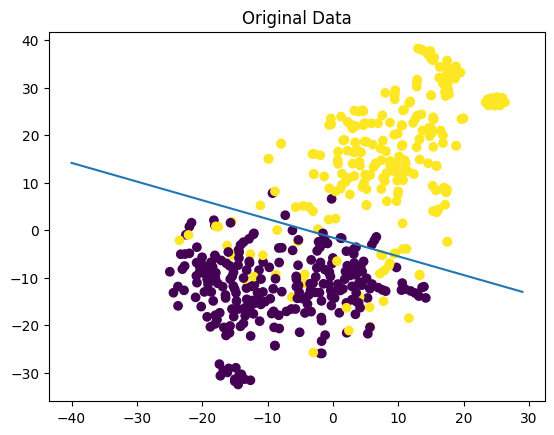

In [347]:
model = TSNE(n_components=2)
X_test_2d = model.fit_transform(X)

x_line = np.array(range(-40, 30))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y)
plt.plot(x_line, x_line*np.mean(lin_w)-lin_b)
plt.title('Original Data')
plt.show()

c:\Users\DohyunKim\anaconda3\envs\business_analytics\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\DohyunKim\anaconda3\envs\business_analytics\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


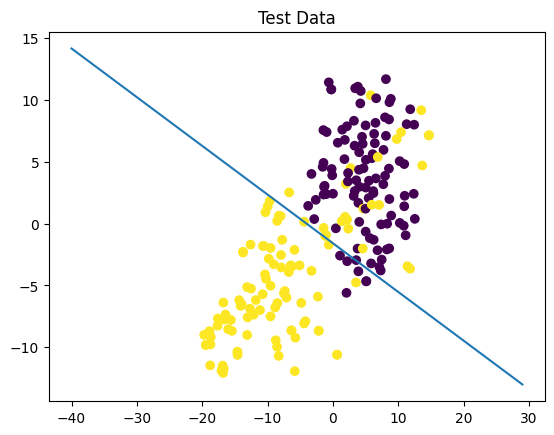

In [354]:
model = TSNE(n_components=2)
X_test_2d = model.fit_transform(X_test_)

x_line = np.array(range(-40, 30))
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_)
plt.plot(x_line, x_line*np.mean(lin_w)-lin_b)
plt.title('Test Data')
plt.show()